In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

base_dir = "C:/Users/Xin/Dropbox/BrainImaging_ML/"
# base_dir = "/home/xin/Dropbox/BrainImaging_ML/"
data_dir = base_dir + "data"

# input_dir = "/home/xin/Dropbox/BrainImaging_ML/multidimensional_age_prediction/out03_age_prediction"
input_dir = "out03_age_prediction_hc2_stdz_age_reverse_fa_scale_thresh0.02"
# input_dir = "out03_age_prediction_hc3_stdz_age_reverse_fa"

# model = 'vvi2'
model = 'cluster_km4'
# model = 'cluster_gmm' # for sklearn reuslts
# model = 'cluster_km'
method = 'ridge'
# method = 'svrlinear'


# select a more strict criterion for HCs:
hc_column = 'mental_hc2'

## Healthy control:
scatter_data_hc = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_" + model + ".csv", 
                              sep = ",", header = 0, index_col=0)
scatter_data_hc['group'] = 'HC'
scatter_data_hc['Sex'] = (scatter_data_hc['Sex']+1)/2
scatter_data_hc['Sex'].astype('int32')

# select mental healthy subjects:
behav_data = pd.read_csv(data_dir+"/pyresult01_pnc_behav_mental4.csv", delimiter = ",")
behav_data = behav_data.astype({'SUBJID': 'int64'})
behav_data["Med_Rating"] = behav_data["Med_Rating"].apply(pd.to_numeric, errors='coerce')
behav_data = behav_data.loc[behav_data["Med_Rating"]<2,:]

behav_data_hc = behav_data.loc[behav_data[hc_column]==True, 'SUBJID']

## select a subset of strict HCs:
scatter_data_hc = scatter_data_hc.loc[scatter_data_hc['SUBJID'].isin(behav_data_hc),:]

## disorder groups:
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_disorder_" + model + ".csv", 
                           sep = ",", header = 0, index_col=0)

## combine hc and disorder groups:
scatter_data = pd.concat([scatter_data_hc, scatter_data])
scatter_data["cluster"].apply(pd.to_numeric, errors='coerce')
# scatter_data['cluster'].astype('int32')

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

# scatter_data.set_index('cluster', inplace = True)
# scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str') 
scatter_data['group'].unique()

array(['HC', 'smry_ptd', 'smry_dep', 'smry_phb', 'smry_soc', 'smry_add',
       'smry_odd'], dtype=object)

In [2]:
scatter_data_hc

,cluster,SUBJID,CV,chronological age,brain age,Sex,group
0,2.0,600009963128,1,9.0,10.976847,0.0,HC
1,2.0,600110937794,1,10.0,8.561033,0.0,HC
2,2.0,600409285352,1,16.0,17.760315,1.0,HC
3,2.0,600647003585,1,18.0,16.192080,0.0,HC
4,2.0,600883641613,1,19.0,17.957801,1.0,HC
...,...,...,...,...,...,...,...
50,all,608993118659,3,19.0,16.080112,0.0,HC
51,all,609072841451,3,18.0,15.416349,0.0,HC
52,all,609485506588,3,20.0,16.137952,0.0,HC
53,all,609575311394,3,12.0,14.450343,1.0,HC


In [3]:


scatter_data['cluster'].unique()

array(['2.0', '4.0', '3.0', '1.0', 'all'], dtype=object)

In [4]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data['cluster'].unique()
group_list = scatter_data['group'].unique()

regr = linear_model.LinearRegression()

for icluster in cluster_list:
#     for igroup in group_list[1:]:

    row_index_hc = (scatter_data['cluster']==icluster)&(scatter_data['group']=='HC')
    row_index = (scatter_data['cluster']==icluster)
    
    scatter_data_cluster = scatter_data.loc[row_index_hc,:]
    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the test set
    scatter_data_cluster = scatter_data.loc[row_index,:]
    X_test = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                        np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))
    
    X_test = np.hstack((X_test,
                         np.vstack((X_test[:,0]*X_test[:,1])), 
                         np.vstack((X_test[:,0]*X_test[:,2]))))
    
    y_pred = regr.predict(X_test)

    scatter_data.loc[row_index, 'brain age fit intersex'] = y_pred

#scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)
scatter_data.replace({'Sex': {0: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(input_dir+"/out04_scatter_data_" + method + "_" + model +"_fit_brain_age.csv")


In [5]:
scatter_data['group'] = scatter_data['group'].map({'HC': 'HC',
                                                   'smry_phb': 'Specific phobia', 
                                                   'smry_soc': 'Social phobia',
                                                   'smry_dep': 'Depression',
                                                   'smry_ptd': 'PTSD',
                                                   'smry_odd': 'ODD',
                                                   'smry_add': 'ADHD'})

# scatter_data

In [6]:
# correction for Kmeans:

# scatter_data['cluster'] = scatter_data['cluster'].map({'1': '1.0',
#                                                        '2': '2.0',
#                                                        '3': '3.0',
#                                                        'all': 'all',
#                                                       })

In [7]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster']=='1.0',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific phobia', 
                                                                'Social phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

demo_summary = scatter_data.loc[scatter_data['cluster']=='1.0', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary

,group,sample size,females,age (mean),age (std)
0,HC,166,82,14.506024,3.794329
1,Specific phobia,185,120,13.600000,3.191701
2,Social phobia,142,82,14.457746,2.829989
3,Depression,70,47,16.000000,2.407717
4,PTSD,71,51,15.507042,2.724876
5,ODD,206,112,14.359223,2.519599
6,ADHD,106,51,13.377358,2.983934


In [8]:
# remove subjects with comobidity (with more than one disorder):
# comorbity subject were just removed from the larger disorder group.
scatter_data['group2'] = scatter_data['group'].map({'HC': 'aHC',
                                                   'Specific phobia': 'fSpecific phobia', 
                                                   'Social phobia': 'eSocial phobia',
                                                   'Depression': 'bDepression',
                                                   'PTSD': 'cPTSD',
                                                   'ODD': 'gODD',
                                                   'ADHD': 'dADHD'})


scatter_data = scatter_data.sort_values(by = ['group2'], ascending = True)
scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep='first')
# scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep=False)


scatter_data['cluster2'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
                                                       '5.0': 'cluster 5',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster2'] = pd.Categorical(scatter_data['cluster2'], ordered=True, categories=column_title)
# cat_type = CategoricalDtype(categories=column_title, ordered=True)
# scatter_data['cluster2'] = scatter_data['cluster2'].astype(cat_type)

# cat_type = CategoricalDtype(categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'], 
#                             ordered=True)
# scatter_data['group2'] = scatter_data['group'].astype(cat_type)

scatter_data['group2'] = pd.Categorical(scatter_data['group'], ordered=True,
                                        categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
# scatter_data

In [9]:
scatter_data['group2'].unique().sort_values()

[HC, Specific phobia, Social phobia, Depression, PTSD, ODD, ADHD]
Categories (7, object): [HC < Specific phobia < Social phobia < Depression < PTSD < ODD < ADHD]

In [10]:
column_title

['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster all']

In [11]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster2']=='cluster 1',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific phobia', 
                                                                'Social phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

group
HC                 82
Specific phobia    46
Social phobia      43
Depression         47
PTSD               31
ODD                20
ADHD               37
Name: (chronological age, count), dtype: int64

In [12]:
demo_summary = scatter_data.loc[scatter_data['cluster2']=='cluster 1', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary.to_csv(input_dir+"/out04_demo_summary.csv")
demo_summary

,group,sample size,females,age (mean),age (std)
0,HC,166,82,14.506024,3.794329
1,Specific phobia,70,46,12.571429,3.169471
2,Social phobia,77,43,14.051948,2.851113
3,Depression,70,47,16.000000,2.407717
4,PTSD,44,31,15.159091,2.836172
5,ODD,48,20,14.562500,2.657036
6,ADHD,81,37,13.086420,2.967312


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

def qudratic_r_squared_gender(chro_age, brain_age, gender):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age and gender.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c, d, e, f):
        x1, x2 = x
        #return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 f*(x1**2)*x2
        return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 + f*(x1**2)*x2
    
    popt, pcov = curve_fit(qudratic_fun, (chro_age, gender), brain_age)
    brain_age_pred = qudratic_fun((chro_age, gender), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

In [14]:
scatter_data

,index,cluster,SUBJID,CV,chronological age,brain age,Sex,group,brain age fit intersex,age gap,age gap corr,group2,cluster2
0,0,2.0,600009963128,1.0,9.0,10.976847,F,HC,10.654757,1.976847,0.322090,HC,cluster 2
547,49,1.0,609173350200,1.0,12.0,15.188943,M,HC,14.131813,3.188943,1.057130,HC,cluster 1
548,50,1.0,609259470422,1.0,10.0,13.275502,F,HC,13.314092,3.275502,-0.038590,HC,cluster 1
549,51,1.0,609262364081,1.0,13.0,15.967759,F,HC,14.266478,2.967759,1.701281,HC,cluster 1
550,52,1.0,609652761759,1.0,19.0,14.531517,F,HC,15.248637,-4.468483,-0.717120,HC,cluster 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,618,1.0,606855754171,NaN,16.0,17.883238,M,ODD,14.885459,1.883238,2.997778,ODD,cluster 1
3092,593,1.0,606673058004,NaN,17.0,13.030982,M,ODD,15.080735,-3.969018,-2.049753,ODD,cluster 1
3090,587,1.0,606531042603,NaN,17.0,13.408319,F,ODD,15.057934,-3.591681,-1.649615,ODD,cluster 1
3087,573,1.0,606304691757,NaN,21.0,15.290436,M,ODD,15.889293,-5.709564,-0.598857,ODD,cluster 1


In [15]:
import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM
import pingouin as pg

scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster2']!='cluster all',:]
scatter_data2['cluster2'] = scatter_data2['cluster2'].cat.remove_unused_categories()

cluster_idx = scatter_data2['cluster2'].unique().sort_values()
num_cluster = len(cluster_idx)

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster']!='all',:]

# model = ols('BAG ~ C(group)*C(cluster)', scatter_data2).fit()
# model.summary()

# aovrm2way = AnovaRM(scatter_data2, 'BAG', 'SUBJID', between = ['group'], within=['cluster'])
# res2way = aovrm2way.fit()
# print(res2way)

aov = pg.mixed_anova(data=scatter_data2, dv='BAG', between='group', within='cluster',
                     subject='SUBJID', correction='auto' )
pg.print_table(aov)

# aov = pg.mixed_anova(data=scatter_data2, dv='age gap', between='group', within='cluster',
#                      subject='SUBJID', correction='auto' )
# pg.print_table(aov)



ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc  p-GG-corr              np2  eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -------------------  -----  -----  ------------  ---------  -----------------------
group        102.156      6    549  17.026  2.028    0.060  -                    0.022  -      -             -          -
cluster       19.384      4   2196   4.846  2.987    0.018  0.04017775639443017  0.005  0.669  False         0.215      3.3469445662328723e-177
Interaction  157.882     24   2196   6.578  4.054    0.000  -                    0.042  -      -             -          -



In [16]:
scatter_data2['cluster'].unique()

array(['2.0', '1.0', '3.0', 'all', '4.0'], dtype=object)

In [17]:
#library(permuco)
#aovperm(nMVPA_42 ~ Cond , data = data )

report = pd.DataFrame(columns = ['disorder', 'p value(group)', 'p value(cluster)', 'p value(interaction)']) 
group_label = list(scatter_data2['group2'].unique().sort_values())
# group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
report['disorder'] = group_label[1:]

i=0
for dis in group_label[1:]:
    print(dis)
    
    scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
    aov = pg.mixed_anova(data=scatter_data_dis, dv='BAG', between='group', within='cluster',
                         subject='SUBJID', correction='auto')
    
    report.iloc[i,1:] = aov['p-unc'].values
    i+=1
    pg.print_table(aov)

Specific phobia

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr               np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  --------------------  -----  -----  ------------  ---------  ----------------------
group        30.398      1    234  30.398  3.350    0.068  -                     0.014  -      -             -          -
cluster      23.191      4    936   5.798  3.876    0.004  0.014216248359224047  0.016  0.667  False         0.225      1.9970248075542103e-69
Interaction  54.996      4    936  13.749  9.191    0.000  -                     0.038  -      -             -          -

Social phobia

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  -----  -----  -----  -----  -----  -------  ------------------  -----  -----  ------------  ---------  ----------------------
group        1.0

C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs



Source           SS    DF1    DF2     MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  -----  -----  -------  ------------------  -----  -----  ------------  ---------  ---------------------
group         0.379      1    208  0.379  0.038    0.846  -                   0.000  -      -             -          -
cluster       3.684      4    832  0.921  0.692    0.597  0.5442374831719016  0.003  0.669  False         0.222      7.044848801929321e-62
Interaction  13.898      4    832  3.475  2.612    0.034  -                   0.012  -      -             -          -

ODD

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  ------------------  -----  -----  ------------  ---------  ---------------------
group        41.565      1    212  41.565  4.355    0.038  -           

In [18]:
# i=0
# for dis in group_label[1:]:
#     print(dis)
    
#     scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
#     aov = pg.mixed_anova(data=scatter_data_dis, dv='age gap', between='group', within='cluster',
#                          subject='SUBJID', correction='auto')
    
#     report.iloc[i,1:] = aov['p-unc'].values
#     i+=1
#     pg.print_table(aov)

In [19]:
pd.options.display.float_format = '{:,.5f}'.format

report2 = report.copy()
report2.iloc[:, 1:] = report2.iloc[:, 1:].astype(float).round(3)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report2.iloc[:,1:].le(2)] = report2[
    report2.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

report2[report.iloc[:,1:].le(0.05)] = report2[
    report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report.iloc[:,1:].le(0.01)] = report2[
    report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')


In [20]:
report2.to_csv(input_dir+'/out03_anova_disorder_table' + method + '_' + model + '.csv')
report2

,disorder,p value(group),p value(cluster),p value(interaction)
0,Specific phobia,0.068,0.004**,0.000**
1,Social phobia,0.737,0.973,0.897
2,Depression,0.770,0.138,0.003**
3,PTSD,0.846,0.597,0.034*
4,ODD,0.038*,0.964,0.726
5,ADHD,0.549,0.050,0.001**


In [21]:
column_title = scatter_data2['cluster2'].unique().sort_values()

report_col =['disorder'] + ['p value(' + i +')' for i in column_title]
permutation_report = pd.DataFrame(columns = report_col) 
permutation_report['disorder'] = group_label[1:]
permutation_report

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,NaN,NaN,NaN,NaN,NaN
1,Social phobia,NaN,NaN,NaN,NaN,NaN
2,Depression,NaN,NaN,NaN,NaN,NaN
3,PTSD,NaN,NaN,NaN,NaN,NaN
4,ODD,NaN,NaN,NaN,NaN,NaN
5,ADHD,NaN,NaN,NaN,NaN,NaN


In [22]:
report_col = pd.MultiIndex.from_tuples([(i , j) for i in column_title for j in ['diff', 'p value']])
permutation_report_full = pd.DataFrame(index = group_label[1:], columns = report_col) 
permutation_report_full

cluster 1         cluster 2         cluster 3          \
                     diff p value      diff p value      diff p value   
Specific phobia       NaN     NaN       NaN     NaN       NaN     NaN   
Social phobia         NaN     NaN       NaN     NaN       NaN     NaN   
Depression            NaN     NaN       NaN     NaN       NaN     NaN   
PTSD                  NaN     NaN       NaN     NaN       NaN     NaN   
ODD                   NaN     NaN       NaN     NaN       NaN     NaN   
ADHD                  NaN     NaN       NaN     NaN       NaN     NaN   

                cluster 4         cluster all          
                     diff p value        diff p value  
Specific phobia       NaN     NaN         NaN     NaN  
Social phobia         NaN     NaN         NaN     NaN  
Depression            NaN     NaN         NaN     NaN  
PTSD                  NaN     NaN         NaN     NaN  
ODD                   NaN     NaN         NaN     NaN  
ADHD                  NaN     NaN         NaN     NaN

In [23]:
# permutation test:
from mlxtend.evaluate import permutation_test

i=0
for dis in group_label[1:]:
    print(dis)
    p_dis = []
    for icluster in column_title:
        bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'BAG']
#         bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'age gap']
        ibag_hc =  scatter_data2.loc[(scatter_data2['group']=='HC')&(scatter_data2['cluster2']==icluster), 'BAG']
    
        p_dis1 = permutation_test(ibag_hc, bag_dis1, method='approximate', num_rounds=1000, seed=0)
        p_dis.append(p_dis1)
        
        m_dis1 = np.mean(ibag_hc) - np.mean(bag_dis1)
        
        permutation_report_full.loc[dis, (icluster, 'p value')] = p_dis1
        permutation_report_full.loc[dis, (icluster, 'diff')] = -m_dis1

    permutation_report.iloc[i,1:] = p_dis
    i+=1

print(permutation_report)


Specific phobia
Social phobia
Depression
PTSD
ODD
ADHD
          disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific phobia            0.00000            0.30600            0.01700   
1    Social phobia            0.74600            0.65900            0.87000   
2       Depression            0.22300            0.82400            0.49700   
3             PTSD            0.18300            0.40500            0.24100   
4              ODD            0.20200            0.00600            0.06500   
5             ADHD            0.00400            0.83800            0.63200   

  p value(cluster 4) p value(cluster all)  
0            0.04000              0.01100  
1            0.78000              0.48900  
2            0.02000              0.70000  
3            0.57000              0.49100  
4            0.33600              0.07400  
5            0.18900              0.61300  


In [24]:
permutation_report_full.loc[:, (slice(None), 'diff')]

,cluster 1,cluster 2,cluster 3,cluster 4,cluster all
,diff,diff,diff,diff,diff
Specific phobia,-0.80754,-0.25528,-0.59391,0.52404,-0.62427
Social phobia,-0.07659,-0.10822,-0.04211,0.07255,-0.16155
Depression,0.29658,-0.05179,0.15875,-0.58843,-0.09143
PTSD,-0.38632,0.24893,0.35110,-0.18486,0.20455
ODD,0.37176,0.67694,0.50679,0.31630,0.49075
ADHD,-0.68814,0.05124,-0.11309,0.31078,-0.12061


In [25]:
pd.options.display.float_format = '{:,.6f}'.format

permutation_report2 = permutation_report.copy()
permutation_report2.iloc[:, 1:] = permutation_report2.iloc[:, 1:].astype(float).round(3)

# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

permutation_report2[permutation_report.iloc[:,1:].le(2)] = permutation_report2[
    permutation_report.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report2[permutation_report.iloc[:,1:].le(0.05)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report2[permutation_report.iloc[:,1:].le(0.01)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report2.to_csv(input_dir+'/out03_permutation_disorder_table' + method + '_' + model + '.csv')
permutation_report2

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,0.000**,0.306,0.017*,0.040*,0.011*
1,Social phobia,0.746,0.659,0.870,0.780,0.489
2,Depression,0.223,0.824,0.497,0.020*,0.700
3,PTSD,0.183,0.405,0.241,0.570,0.491
4,ODD,0.202,0.006**,0.065,0.336,0.074
5,ADHD,0.004**,0.838,0.632,0.189,0.613


In [26]:
pd.options.display.float_format = '{:,.6f}'.format

permutation_report_full2 = permutation_report_full.copy()
permutation_report_full2 = permutation_report_full2.astype(float).round(3).astype(str)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

# convert numeric value to strings with 3 decimal digits:
permutation_report_full2[permutation_report_full.le(0)] = permutation_report_full2[
    permutation_report_full.le(0)].astype(str).apply(lambda x : x.str[:6]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.ge(0)] = permutation_report_full2[
    permutation_report_full.ge(0)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report_full2.to_csv(input_dir+'/out03_permutation_disorder_table_full_' + method + '_' + model + '.csv')
permutation_report_full2

cluster 1          cluster 2          cluster 3          \
                     diff  p value      diff  p value      diff p value   
Specific phobia    -0.808  0.000**    -0.255    0.306    -0.594  0.017*   
Social phobia      -0.077    0.746    -0.108    0.659    -0.042   0.870   
Depression          0.297    0.223    -0.052    0.824     0.159   0.497   
PTSD               -0.386    0.183     0.249    0.405     0.351   0.241   
ODD                 0.372    0.202     0.677  0.006**     0.507   0.065   
ADHD               -0.688  0.004**     0.051    0.838    -0.113   0.632   

                cluster 4         cluster all          
                     diff p value        diff p value  
Specific phobia     0.524  0.040*      -0.624  0.011*  
Social phobia       0.073   0.780      -0.162   0.489  
Depression         -0.588  0.020*      -0.091   0.700  
PTSD               -0.185   0.570       0.205   0.491  
ODD                 0.316   0.336       0.491   0.074  
ADHD                0.311   0.189      -0.121   0.613

In [27]:

def box_plot(scatter_data, permutation_report, p_thresh = .07):
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(24, 9)}, font_scale = 2)

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})


    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)

    scatter_data_group = scatter_data2[scatter_data2['group'].isin(group_label)]
    scatter_data_group.to_csv(input_dir+'/out04_scatter_data_all.csv')

    f, (ax1) = plt.subplots(1, sharex=True)

    # x_order =  ['HC', 'smry_phb', 'smry_soc', 'smry_dep', 'smry_ptd', 'smry_odd', 'smry_add']

    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data_group, 
                  hue = 'group2', dodge=True, ax = ax1,
                 palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                 alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
                notch = True, ax = ax1)


    # sns.swarmplot(y = "age gap", x = "cluster2", data = scatter_data_group, 
    #               hue = 'group2', dodge=True, ax = ax1,
    #              palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
    #              alpha = .75)

    # sns.boxplot(y = "age gap", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
    #             notch = True, ax = ax1)

    ax1.set(xlabel='', ylabel='brain age gap corr')

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = plt.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'upper right', 
                   prop = {'size': 13}, title = '',bbox_to_anchor=(1.11, 0.7), ncol=1)

    # cluster_idx = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
#     cluster_idx = scatter_data2['cluster2'].unique().sort_values()
#     comparision_pairs = [((cluster, 'HC'), (cluster, disorder)) 
#                          for cluster in cluster_idx 
#                              for disorder in group_label[1:]]

    # add_stat_annotation(ax1, y = "age gap corr", x = "cluster", data = scatter_data, hue = 'group', 
    #                     box_pairs = comparision_pairs,
    #                     test='t-test_ind', 
    #                     comparisons_correction = 'bonferroni',
    # #                     comparisons_correction = None,
    #                     line_height=0.01, fontsize='small', color='0.2', linewidth=1, 
    #                     text_format='simple', loc='inside', verbose=2)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color)


    y_base = np.array([1]*num_cluster)*7.5

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    plt.tight_layout()
    plt.show()
    return(f)


# f = box_plot(scatter_data, permutation_report)    
# f.savefig(input_dir+'/figure4_boxplot_age_gap_' + method + '_disorder_'+model+'.png', dpi=300)

${p}$<.001
${p}$=0.017
${p}$=0.040
${p}$=0.011
${p}$=0.020
${p}$=0.006
${p}$=0.065
${p}$=0.004


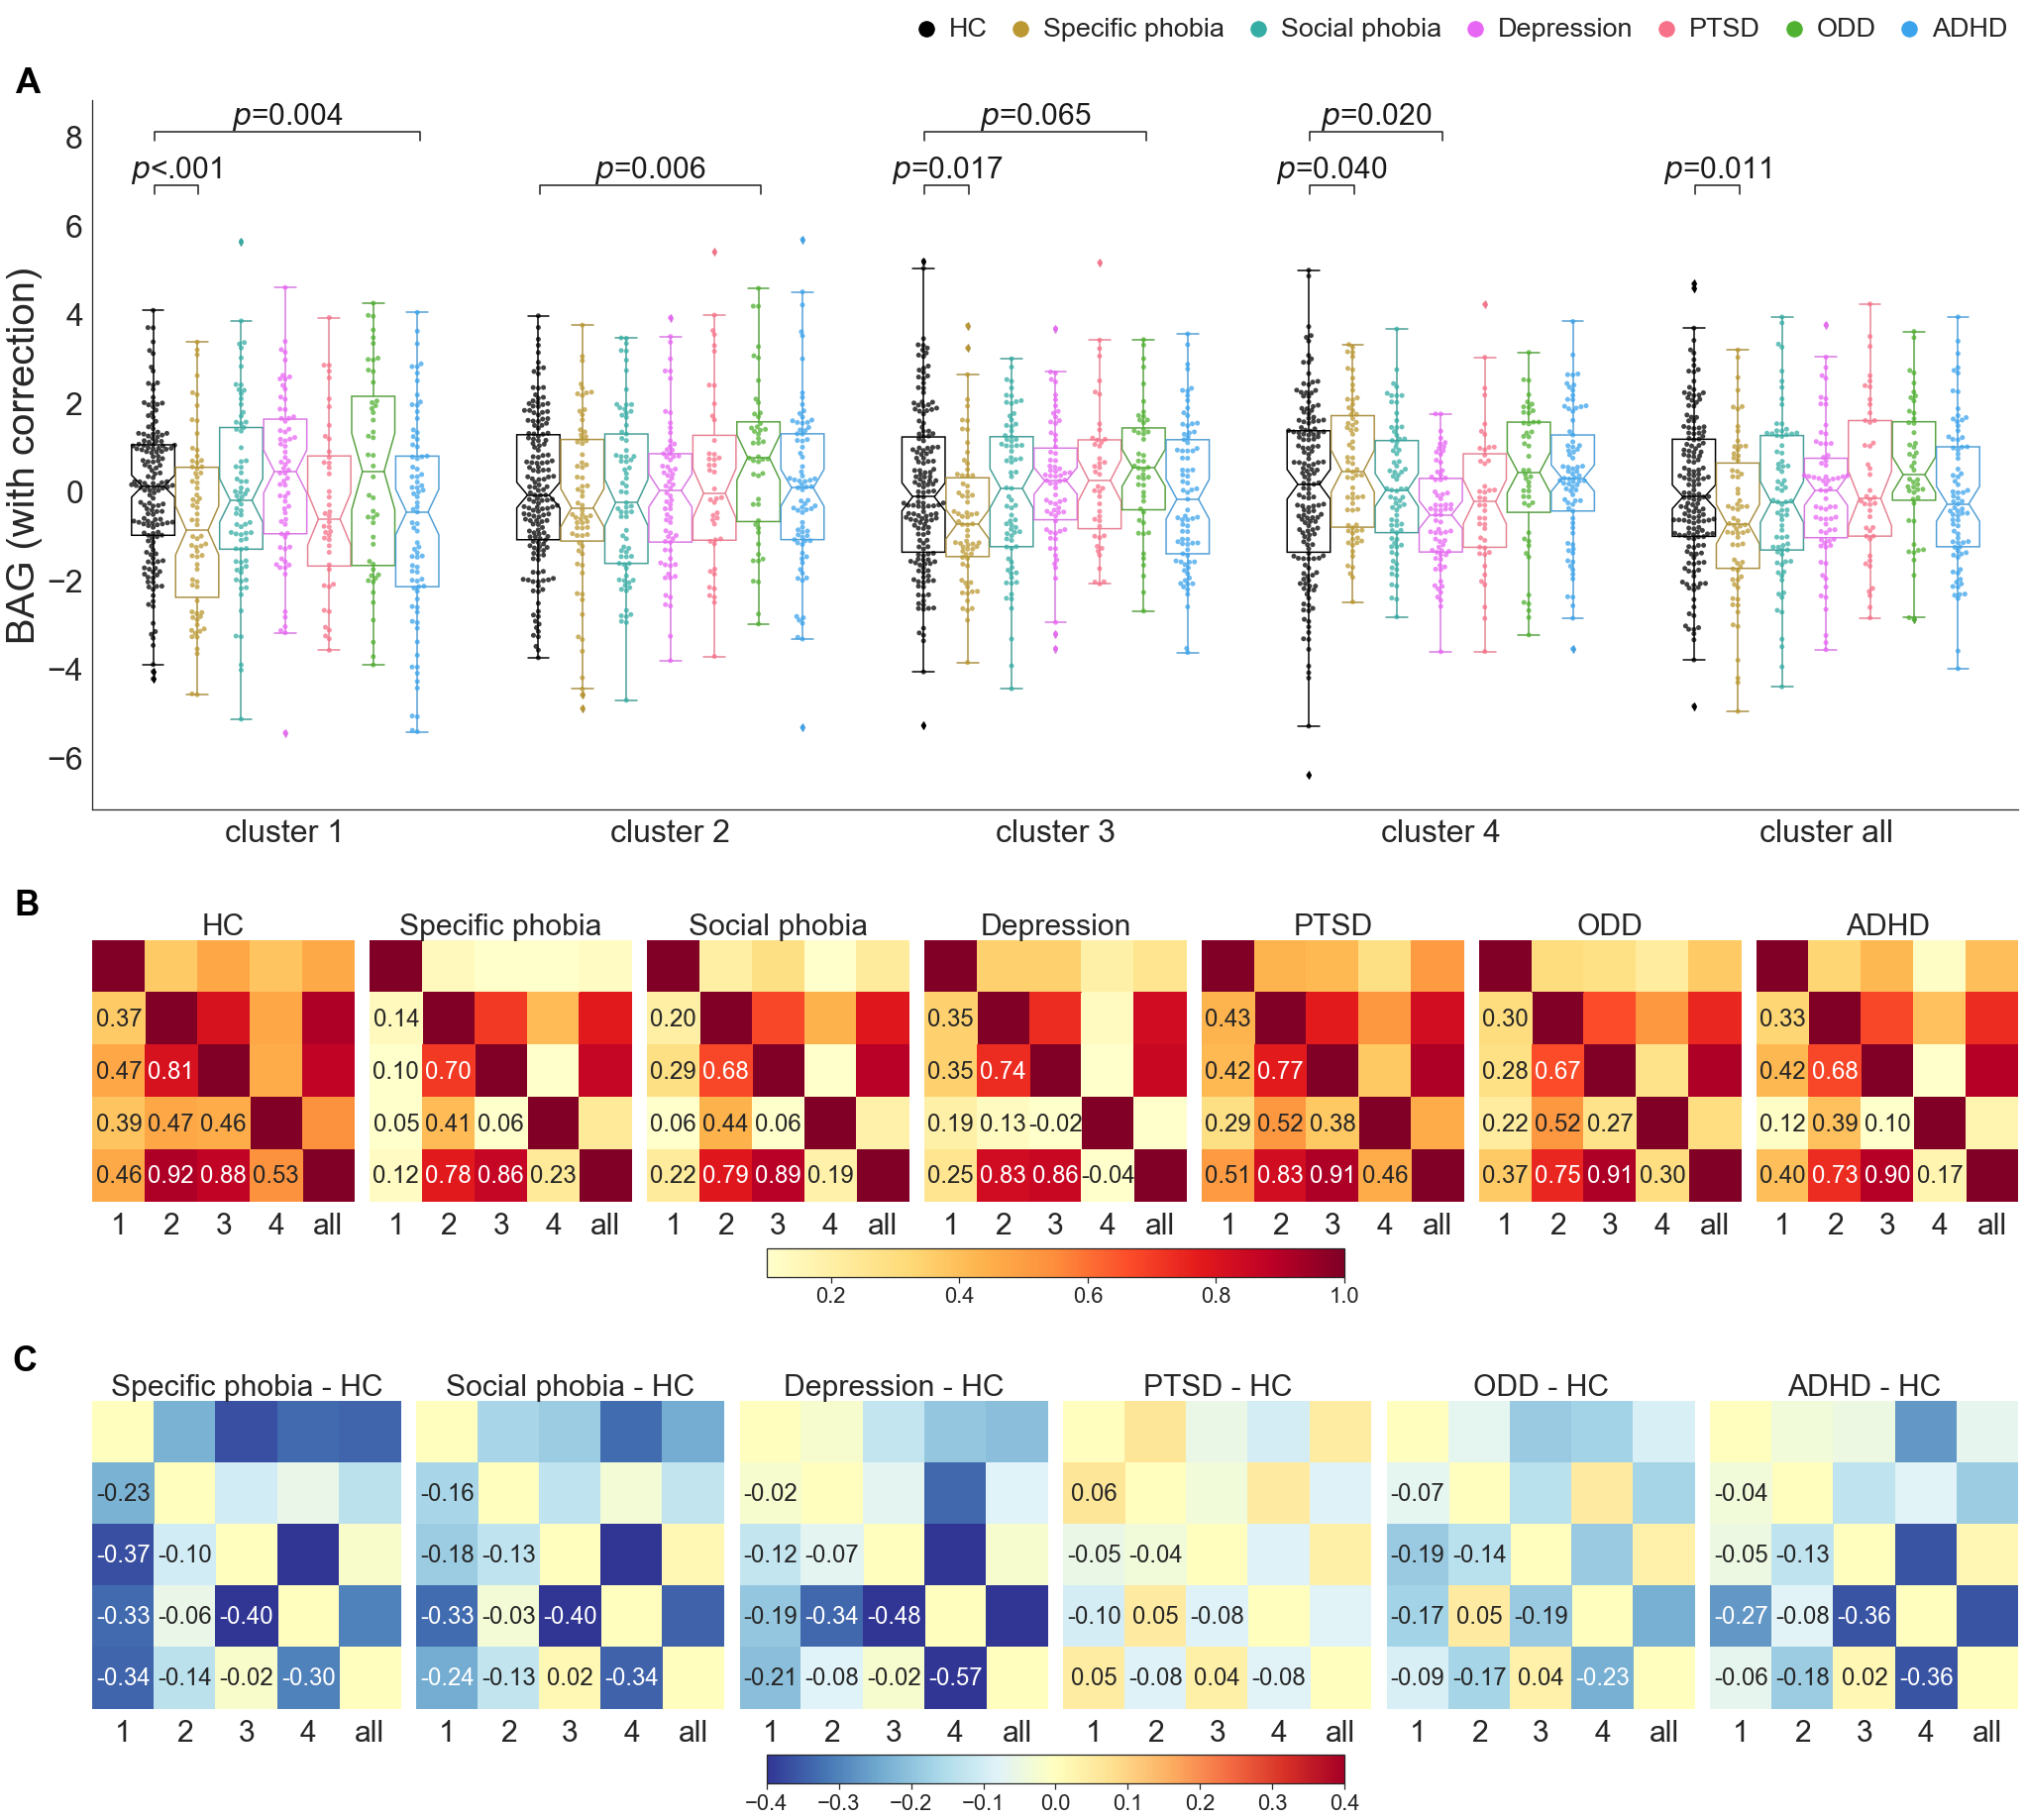

In [46]:
def box_heatmap_plot(scatter_data, permutation_report, p_thresh = .07):
    
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(30, 32)}, font_scale = 2)
    sns.set_style("white")

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)
    group_label = list(scatter_data['group2'].unique().sort_values())
    num_group = len(group_label)

    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=7, ncols=num_group*(num_group-1), left=0.05, right=0.95, wspace=0.5, hspace = .25)
    
    ax1 = fig.add_subplot(gs[0:3, :])
    
    ax2_list = []
    gs_coord1 = range(0, num_group*(num_group-1), num_group-1)
    gs_coord2 = range(num_group-1, num_group*(num_group-1)+1, num_group-1)
    for i_subplot in range(num_group):
        ax2_list.append(fig.add_subplot(gs[3:5, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))
        
    ax3_list = []  
    gs_coord1 = range(0, num_group*(num_group-1), num_group)
    gs_coord2 = range(num_group, num_group*(num_group-1)+1, num_group)
    for i_subplot in range(num_group-1):
        ax3_list.append(fig.add_subplot(gs[5:, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))

    ############ box plot: ###########################
    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data2, 
                  hue = 'group2', dodge=True, ax = ax1,
                  palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data2, hue = 'group2', palette = colors,
                notch = True, ax = ax1)

#     ax1.set(xlabel='', ylabel='BAG (with correction)')
    ax1.set_xlabel('')
    ax1.set_ylabel('BAG (with correction)', size = 40)
    ax1.tick_params(axis='x', labelsize=32)
    ax1.tick_params(axis='y', labelsize=32)
    #ax1.set_xticklabels(cluster_idx, size = 35)
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = ax1.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'right', columnspacing = 1.2,
                   frameon = False, markerscale =2, handlelength = .1,
                   prop = {'size': 27}, title = '', bbox_to_anchor=(1, 1.1), ncol=7)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color, size = 30)


    y_base = np.array([1]*num_cluster)*6.7

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    ax1.text(-.7, 9, "A", horizontalalignment='left', size=35, color='black', weight='bold')
    
    ############################# heat map #################################
    
    idx = 0
    idx2= 0
    for i_group in group_label:
        
        scatter_data_group = scatter_data2.loc[scatter_data2['group2']==i_group,['SUBJID', 'cluster2', 'BAG']]
        scatter_data_group = scatter_data_group.pivot(index='SUBJID', columns='cluster2', values='BAG')
        matrix = scatter_data_group.corr()
        

        ## panel B:
        cmap_b = 'YlOrRd'
        # draw upper triangular heat map without annotation:
        im = sns.heatmap(matrix, annot=False, ax = ax2_list[idx], 
                         cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        # draw lower triangular heat map with annotation:
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        im = sns.heatmap(matrix, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                         ax = ax2_list[idx], cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        
        ax2_list[idx].set_ylabel("")
        ax2_list[idx].set_yticklabels("")
        ax2_list[idx].set_title(i_group, size = 30)
        ax2_list[idx].set_xlabel('')
        ax2_list[idx].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)

        cmap_c = 'RdYlBu_r'
        ## panel C:
        if idx==0:
            matrix_hc = matrix
        else:
            # draw upper triangular heat map without annotation:
            im2 = sns.heatmap(matrix-matrix_hc, annot=False, ax = ax3_list[idx2], 
                         cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)
            # draw lower triangular heat map with annotation:
            mask = np.triu(np.ones_like(matrix, dtype=np.bool))
            im2 = sns.heatmap(matrix-matrix_hc, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                             ax = ax3_list[idx2], cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)

            ax3_list[idx2].set_ylabel("")
            ax3_list[idx2].set_yticklabels("")
            ax3_list[idx2].set_title(i_group+ ' - HC', size = 30)
            ax3_list[idx2].set_xlabel('')
            ax3_list[idx2].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)
            
            idx2+=1
        
        idx+=1
            
    
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax = ax2_list, shrink = .3, location="bottom", pad = .1,)
    
    mappable = im2.get_children()[0]
    plt.colorbar(mappable, ax = ax3_list, shrink = .3, location="bottom", pad = .1,)
    
    ax2_list[0].text(-1.5, -.5, "B", horizontalalignment='left', size=35, color='black', weight='bold')
    ax3_list[0].text(-1.3, -.5, "C", horizontalalignment='left', size=35, color='black', weight='bold')
    
    #plt.tight_layout()
    plt.show()
    return(fig)

f = box_heatmap_plot(scatter_data, permutation_report)
f.savefig(input_dir+'/figure4_box_heatmap_plot_age_gap_' + method + '_disorder_'+ model + '.png', dpi=300,
          bbox_inches = 'tight', pad_inches = 0.5)

In [29]:
# x = [i/5 for i in range(5)]
# x

In [30]:
from statsmodels.stats.multitest import multipletests
permutation_report_corr = permutation_report.copy()

num_col = permutation_report_corr.shape[1]

for i in range(1, num_col):
    output = multipletests(permutation_report.iloc[:,i],alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    permutation_report_corr.iloc[:, i] = output[1]

permutation_report3 = permutation_report_corr.copy()

permutation_report3.iloc[:,1:] = permutation_report3.iloc[:,1:].astype(float).round(3).astype(str)
permutation_report3[permutation_report_corr.iloc[:,1:].le(2)] = permutation_report3[
    permutation_report_corr.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report3[permutation_report_corr.iloc[:,1:].le(0.05)] = permutation_report3[
    permutation_report_corr.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report3[permutation_report_corr.iloc[:,1:].le(0.01)] = permutation_report3[
    permutation_report_corr.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report3.to_csv(input_dir+'/out03_permutation_disorder_table_bonferroni' + method + '_' + model + '.csv')
permutation_report3

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,0.000**,1.000,0.102,0.240,0.066
1,Social phobia,1.000,1.000,1.000,1.000,1.000
2,Depression,1.000,1.000,1.000,0.120,1.000
3,PTSD,1.000,1.000,1.000,1.000,1.000
4,ODD,1.000,0.036*,0.390,1.000,0.444
5,ADHD,0.024*,1.000,1.000,1.000,1.000


In [31]:
pd.options.display.float_format = '{:,.5f}'.format

permutation_report_fdr = permutation_report.copy()

correction_method = 'hommel'
correction_method = 'holm'

for i in range(1, num_col):
    output = multipletests(permutation_report.iloc[:,i],alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
    permutation_report_fdr.iloc[:, i] = output[1]

permutation_report4 = permutation_report_fdr.copy()

permutation_report4.iloc[:,1:] = permutation_report4.iloc[:,1:].astype(float).round(3).astype(str)

permutation_report4[permutation_report_fdr.iloc[:,1:].le(2)] = permutation_report4[
    permutation_report_fdr.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report4[permutation_report_fdr.iloc[:,1:].le(0.05)] = permutation_report4[
    permutation_report_fdr.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report4[permutation_report_fdr.iloc[:,1:].le(0.01)] = permutation_report4[
    permutation_report_fdr.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report4.to_csv(input_dir+'/out03_permutation_disorder_table_' + correction_method + '_' + model + '.csv')
permutation_report4

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,0.000**,1.000,0.102,0.200,0.066
1,Social phobia,0.746,1.000,1.000,1.000,1.000
2,Depression,0.732,1.000,1.000,0.120,1.000
3,PTSD,0.732,1.000,0.964,1.000,1.000
4,ODD,0.732,0.036*,0.325,1.000,0.370
5,ADHD,0.020*,1.000,1.000,0.756,1.000


${p}$<.001
${p}$=0.066
${p}$=0.036
${p}$=0.020


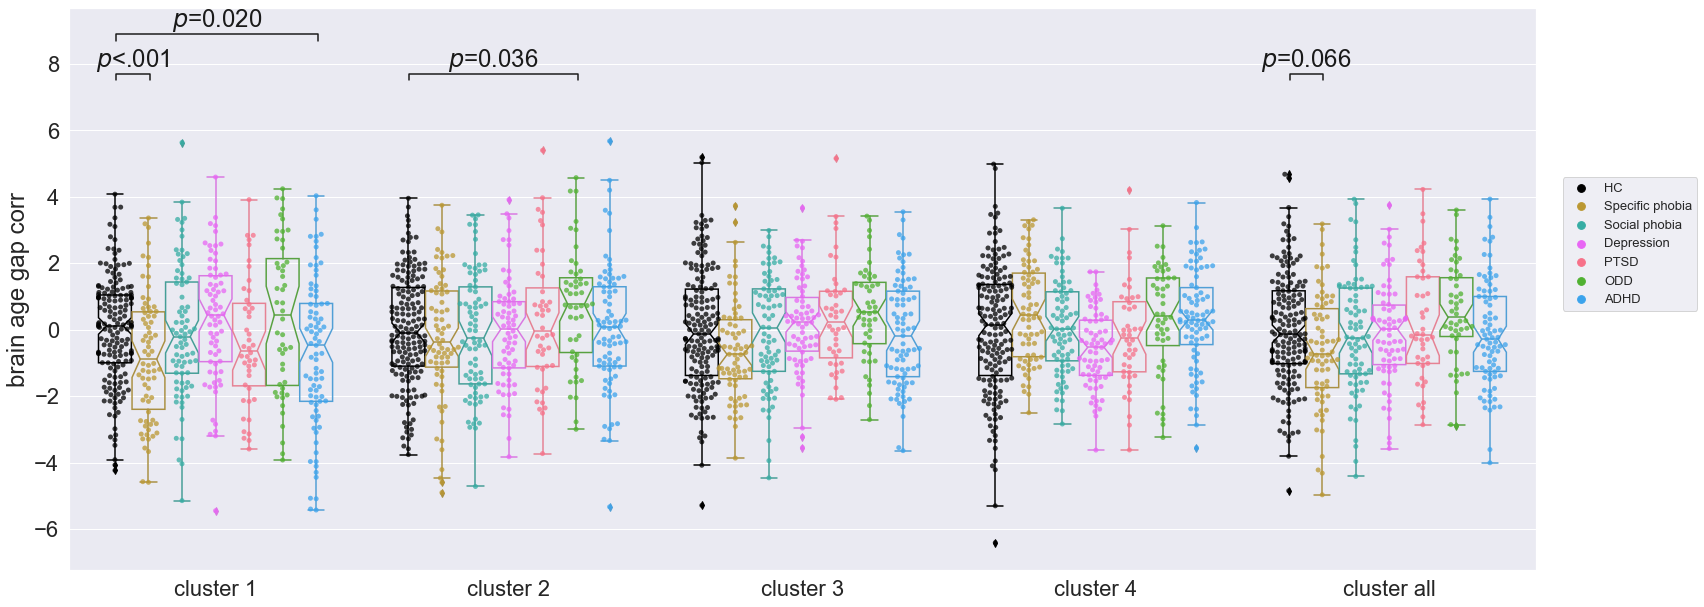

In [32]:
f = box_plot(scatter_data, permutation_report_fdr, p_thresh = .1)
f.savefig(input_dir+'/figure4_boxplot_age_gap_' + method + '_disorder_'+ model +'_' + correction_method + '.png', dpi=300)

In [33]:
scatter_data2['cluster2'].unique().sort_values()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


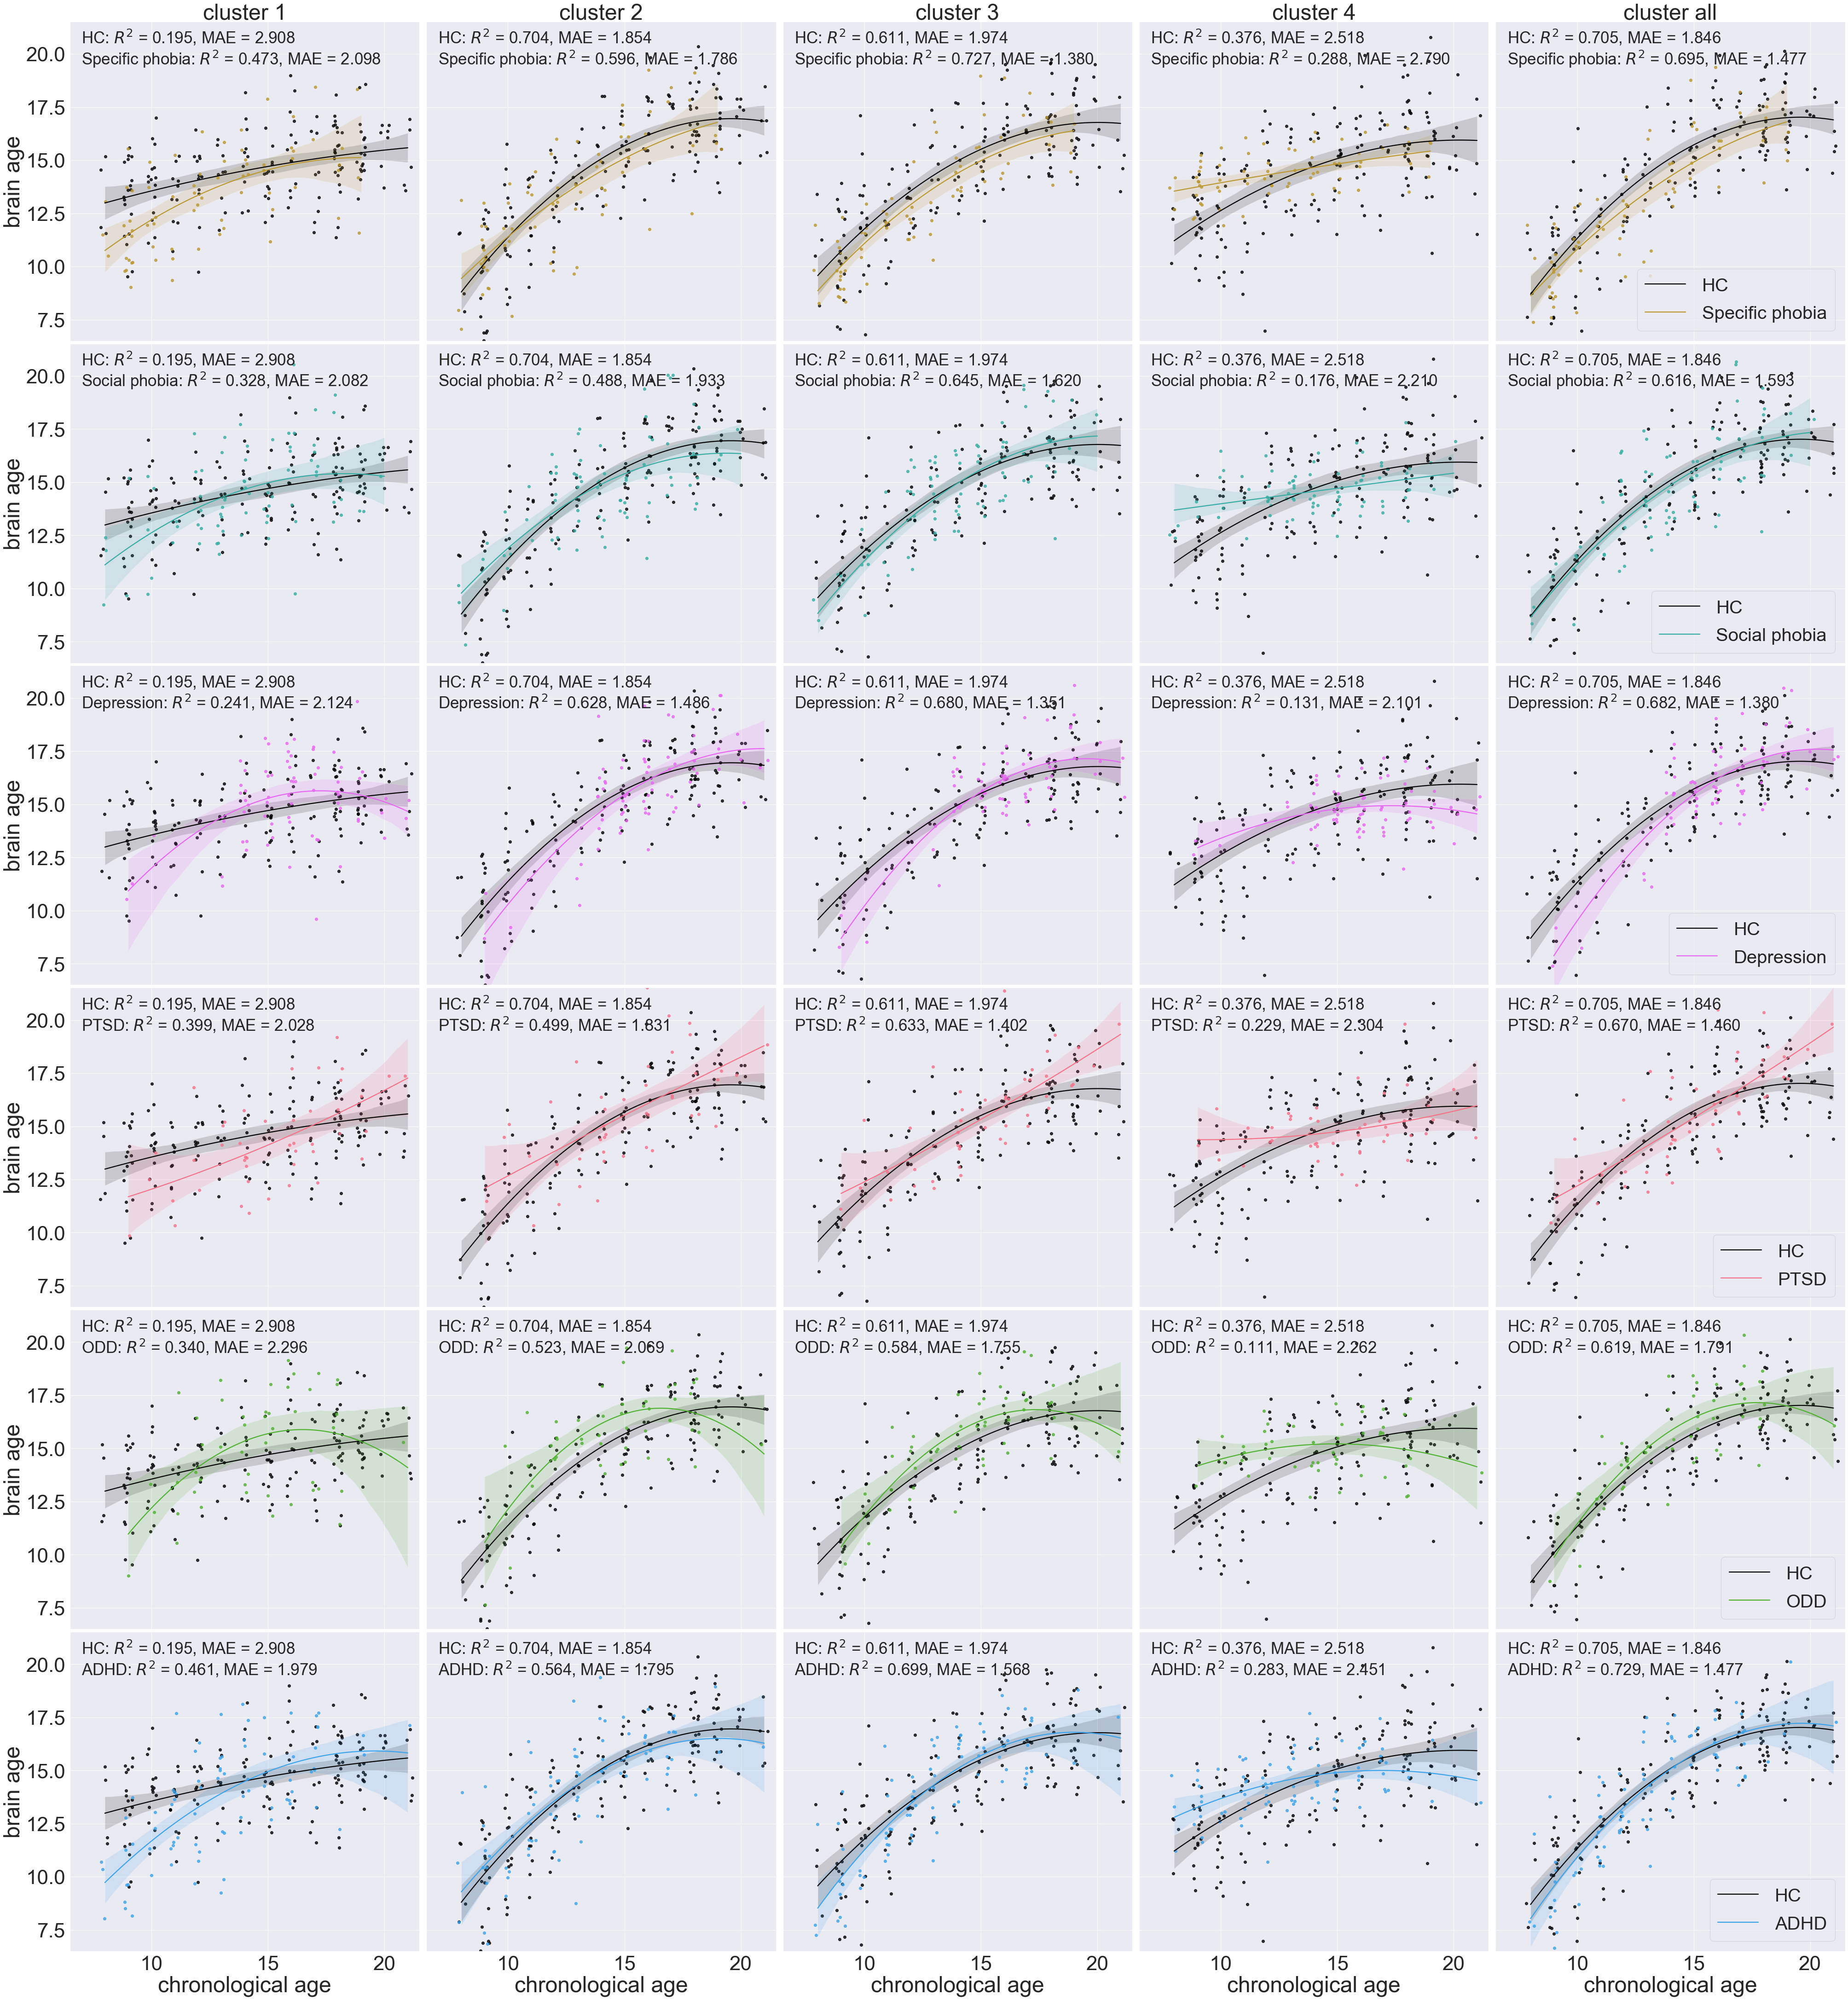

In [34]:
sns.set(rc={'figure.figsize':(9, 8)}, font_scale = 4)
text_size = 35

group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Social anxiety', 'ODD', 'ADHD']

# colors = sns.color_palette("RdBu_r", 7)
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
colors = colors[::2] + colors[1::2] 

scatter_para = {'alpha': 0.9, 's': 3, 'linewidth': 0.1}

def plot_result_disorder(plot_data, group_label):

    plot_data['plot_row'] = 1
    column_title = plot_data['cluster2'].unique().sort_values()
    plot_data_list = []
    for i in range(1, len(group_label)):
        plot_data_i = plot_data[plot_data['group'].isin([group_label[0]]+[group_label[i]])]
        plot_data_i.loc[:,'plot_row'] = i
        plot_data_list.append(plot_data_i)
        
    plot_data_merge = pd.concat(plot_data_list, axis = 0)
    
#     cluster_name = plot_data['cluster'].unique()
#     variable_name = plot_data['group'].unique()

    g = sns.lmplot(x='chronological age', y='brain age', hue = 'group', 
                   col = 'cluster2', row = 'plot_row', palette = colors, 
                   data = plot_data_merge, fit_reg=True, sharex = True, sharey = True, \
                   scatter_kws={'alpha':0.8}, x_jitter = .2, order = 2,\
                   height=10.27, aspect=9.17/8.27, legend = False)

    g.axes[0,0].set_xlim(6.5, 21.5)
    g.axes[0,0].set_ylim(6.5, 21.5)

    # comment this to check if column labels are correct:
    for col in range(len(column_title)):
        g.axes[0, col].set_title(column_title[col])
        for row in range(1,len(group_label)-1):
            g.axes[row, col].set_title('')
    
#     plt.setp(g._legend.get_title(), fontsize=45)
#     g._legend.set_title('')
#     for lh in g._legend.legendHandles[:2]: 
#         lh.set_alpha(1)
#         lh._sizes = [200] 
    
    # add legend for each row:
    for row in range(len(group_label)-1):
        g.axes[row, -1].legend(['HC', group_label[row+1]], loc = 'lower right')
        plt.setp(g.axes[row, -1].get_legend().get_texts(), fontsize='40')
            
    # compute R squared for each group and cluster:
    for col in range(len(column_title)):
        chro_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                 'chronological age'].values
        brain_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                  'brain age'].values
        gender = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                               'Sex'].map({'F':0, 'M':1}).values
        
        label_hc = "HC: $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender), 
                                                     np.mean(np.abs(chro_age - brain_age)))
        
        for row in range(len(group_label)-1):
            chro_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                     'chronological age'].values
            brain_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                      'brain age'].values
            gender = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                   'Sex'].map({'F':0, 'M':1}).values
            
            label_dis = group_label[row+1]+ ": $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender),
                                                                            np.mean(np.abs(chro_age - brain_age)))
            
            g.axes[row, col].text(7, 20.5, label_hc, fontsize = 35)
            g.axes[row, col].text(7, 19.5, label_dis, fontsize = 35)
        
    plt.subplots_adjust(hspace=0.01, wspace=0.02)


plot_result_disorder(scatter_data, group_label)
plt.savefig(input_dir+'/figure4_scatter_merge_' + method + 'disorder' + model + '.png', dpi=300)